# Get N-dimensional Benchmark from P to Q

In [1]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


from eot_benchmark.gaussian_mixture_benchmark import (
    get_guassian_mixture_benchmark_sampler,
    get_guassian_mixture_benchmark_ground_truth_sampler, 
    get_test_input_samples,
)
from eot_benchmark.metrics import (
    compute_BW_UVP_by_gt_samples, compute_BW_by_gt_samples, calculate_cond_bw
)


## Hyper-Parameters

In [2]:
DIM = 16  # 2,16,64,128
EPS =  0.1 # 0.1, 1, 10
SEED = 987
GPU_DEVICE = 0
BATCH_SIZE=1024
NUM_SAMPLES_PLOT=1000
SELECTED_IDX = [233,43,12,62,555]
SELECTED_ITERS = 16
NUM_SAMPLES_METRICS=1000

## 1. Benchmark

In [3]:
input_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="input", dim=DIM, eps=EPS,
                                          batch_size=BATCH_SIZE, device=f"cuda:{GPU_DEVICE}", download=True)

target_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="target", dim=DIM, eps=EPS,
                                          batch_size=BATCH_SIZE, device=f"cuda:{GPU_DEVICE}", download=True)

ground_truth_plan_sampler = get_guassian_mixture_benchmark_ground_truth_sampler(dim=DIM,eps=EPS,
                                                          batch_size=BATCH_SIZE , device=f"cuda:{GPU_DEVICE}",
                                                                                download=True)

Downloading...
From: https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
To: /home/pvmokrov/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84.8M/84.8M [00:01<00:00, 73.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
To: /home/pvmokrov/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84.8M/84.8M [00:01<00:00, 75.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
To: /home/pvmokrov/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84.8M/84.8M [00:01<00:00, 72.2MB/s]


## 2. PCA: motion samples

In [4]:
input_samples = input_sampler.sample(NUM_SAMPLES_PLOT)
target_samples = target_sampler.sample(NUM_SAMPLES_PLOT)

### 2.1 Map points from P by Ground-Truth process

In [5]:
mapped_points = ground_truth_plan_sampler.conditional_plan.sample(input_samples)

### 2.2 Map selected points from P by Ground-Truth process

In [6]:
re_points = []
for step in tqdm(range(SELECTED_ITERS)):
    x = input_samples[SELECTED_IDX]
    xt = ground_truth_plan_sampler.conditional_plan.sample(x)
    re_points.append(xt)
re_points = torch.stack(re_points,dim=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 251.90it/s]


### 2.3 PCA plot

In [7]:
pca = PCA(n_components=2).fit(target_samples.cpu().numpy())
input_data_emb = pca.transform(input_samples.cpu().numpy())
target_data_emb=  pca.transform(target_samples.cpu().numpy())
map_data_emb = pca.transform(mapped_points.cpu().numpy())
 
start_points_emb = pca.transform(input_samples[SELECTED_IDX].cpu().numpy())

pca_re_points=[]
for i in range(len(SELECTED_IDX)):
    pca_re_points.append(pca.transform(re_points[:,i,:].cpu().numpy()))

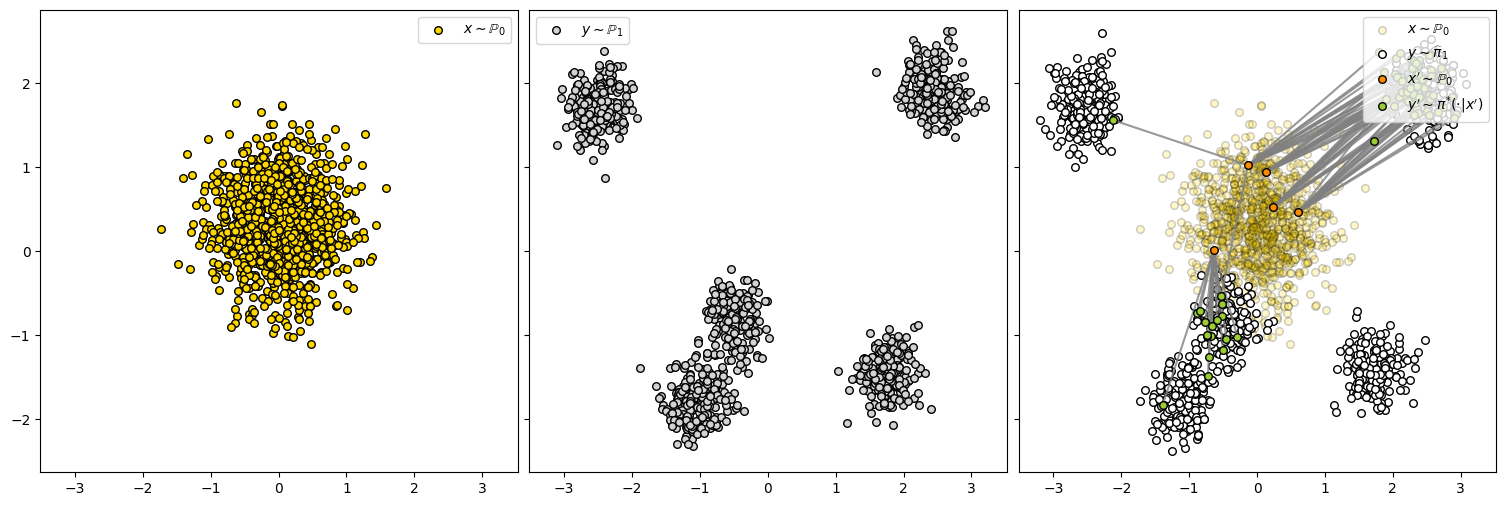

In [8]:
fig,axes = plt.subplots( 1, 3,figsize=(15,5),squeeze=True,sharex=True,sharey=True)

axes[0].scatter( input_data_emb[:,0], input_data_emb[:,1], c="gold", edgecolor = 'black',
                label = r'$x \sim \mathbb{P}_{0}$', s =30)

axes[1].scatter( target_data_emb[:,0],target_data_emb[:,1], c="lightgray", edgecolor = 'black',
                label = r'$y\sim \mathbb{P}_{1}$', s =30)

 
axes[2].scatter( input_data_emb[:,0], input_data_emb[:,1], c="gold", edgecolor = 'black',
                        label = r'$x \sim \mathbb{P}_{0} $', s =30,alpha=0.2)
axes[2].scatter( map_data_emb[:,0], map_data_emb[:,1], c="white", edgecolor = 'black',
                        label = r'$y \sim \widehat\pi_{1}$', s =30,alpha=1)

axes[2].scatter(start_points_emb[:,0],start_points_emb[:,1],c='darkorange',edgecolor='black',
               s=30,label=r"$x' \sim \mathbb{P}_{0}$",zorder=2)


for i in range(len(SELECTED_IDX)):
    axes[2].scatter(pca_re_points[i][:,0], pca_re_points[i][:,1],c='yellowgreen',edgecolor='black',
               s=30,label=r"$y'  \sim  \pi^{*}(\cdot|x')$" if i==len(SELECTED_IDX) - 1 else None,zorder=2)


for j in range(len(SELECTED_IDX)):
    for i in range(SELECTED_ITERS):
        x_values = [start_points_emb[j,0],pca_re_points[j][i,0]]
        y_values = [start_points_emb[j,1],pca_re_points[j][i,1]]
        axes[2].plot(x_values,y_values,color='gray',alpha=0.8,zorder=1)
    
axes[0].legend();axes[1].legend();axes[2].legend(loc='upper right')
fig.tight_layout(pad=0.5)

## 3. Metrics

### 3.1 Target BW-UVP calculation

In [9]:
mapped = torch.mean(target_samples,dim=0).repeat( target_samples.shape[0],1)
bw_uvp_target = compute_BW_UVP_by_gt_samples(mapped.cpu().numpy(), target_samples.cpu().numpy())
bw_uvp_target

100.0000000009794

 ### 3.2 Conditional BW-UVP calculation

In [10]:
test_samples = get_test_input_samples(dim=DIM, device=f"cuda:{GPU_DEVICE}")

In [11]:
predictions = []
for i in tqdm(range(NUM_SAMPLES_METRICS)):
    X_cond = test_samples[i][None, :].repeat(NUM_SAMPLES_METRICS, 1)
    X_cond_predicted = torch.mean(target_samples,dim=0).repeat( X_cond.shape[0],1)

    predictions.append(X_cond_predicted)

predictions = torch.stack(predictions, dim=0)

new_cond_bw = calculate_cond_bw(test_samples, predictions, eps=EPS, dim=DIM)
new_cond_bw            

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11756.98it/s]


100.01378870218447